<font color='blue'> **11_Streamflow Routing_P1** </font> 

In [1]:
import os  ; import flopy ; import matplotlib.pyplot as plt       ; import numpy as np  ; import pickle
from pathlib import Path  ; from flopy.plot.styles import styles  ; import pandas as pd ; import matplotlib as mpl 
from modflow_devtools.misc import get_env ; write=get_env("WRITE",True) ;run=get_env("RUN",True) 

In [2]:
sim_data  = Path("./_aux/11_sfr")          ; sim_data.mkdir(exist_ok=True)
sim_ws    = Path("./11_sfr-p01_b")         ; sim_ws.mkdir  (exist_ok=True)              ; sim_name = "sfr-p01"  ; workspace = sim_ws ; gwf_name = sim_name 
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-sfr-p01'           ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' 
fpath1 = os.path.join(path,"idomain.txt")  ; idomain  = np.loadtxt(fpath1, dtype=int)   ; np.savetxt(sim_ws / "aa1.csv", idomain  , delimiter=",")
fpath2 = os.path.join(path,"top.txt")      ; top      = np.loadtxt(fpath2, dtype=float) ; np.savetxt(sim_ws / "aa2.csv", top      , delimiter=",")
fpath3 = os.path.join(path,"bottom.txt")   ; botm     = np.loadtxt(fpath3, dtype=float) ; np.savetxt(sim_ws / "aa3.csv", botm     , delimiter=",") 
fpath4 = os.path.join(path,"recharge.txt") ; recharge = np.loadtxt(fpath4, dtype=float) ; np.savetxt(sim_ws / "aa4.csv", recharge , delimiter=",")
fpath5 = os.path.join(path,"surf.txt")     ; surf     = np.loadtxt(fpath5, dtype=float) ; np.savetxt(sim_ws / "aa5.csv", surf     , delimiter=",")

In [3]:
length_units = "feet"      ; nlay = 1 ; nrow = 15 ; ncol = 10 ; delr = 5000 ; delc = 5000   ; strt = 1050     ; k11_stream = 0.002  
time_units = "seconds"     ; k11_basin = 0.0004   ; ss = 0.000001      ;  sy_stream = 0.2   ; sy_basin = 0.1  ; evap_rate = 0.000000095 ; ext_depth = 15
nouter = 100 ; ninner = 50 ; hclose = 0.000001    ; rclose = 0.000001  ; nper = 3; tdis_ds = ((0.0, 1, 1.0),(1.577880e9, 50, 1.1),(1.577880e9, 50, 1.1))
extents = (0.0, delr * ncol, 0.0, delc * nrow)    ; shape2d = (nrow, ncol)                  ; print('tdis_ds (50+50 years pump/recovery)=', tdis_ds)
k11 = np.zeros(shape2d, dtype=float)              ; k11[idomain == 1] = k11_stream          ; k11[idomain == 2] = k11_basin
sy = np.zeros(shape2d, dtype=float)               ; sy[idomain == 1] = sy_stream            ; sy[idomain == 2] = sy_basin ; 

tdis_ds (50+50 years pump/recovery)= ((0.0, 1, 1.0), (1577880000.0, 50, 1.1), (1577880000.0, 50, 1.1))


In [4]:
#with open(sim_data/ "a_sfr_pakdata", 'wb') as handle: pickle.dump(sfr_pakdata, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(sim_data/ "a_sfr_pakdata" , 'rb') as handle: sfr_pakdata = pickle.load(handle)   ;a1=pd.DataFrame(sfr_pakdata) ;a1.to_csv(sim_ws/"01_.csv")
with open(sim_data/ "b_sfr_conn   " , 'rb') as handle: sfr_conn    = pickle.load(handle)   ;a1=pd.DataFrame(sfr_conn)    ;a1.to_csv(sim_ws/"02_.csv")
with open(sim_data/ "c_sfr_div    " , 'rb') as handle: sfr_div     = pickle.load(handle)   ;a1=pd.DataFrame(sfr_div)     ;a1.to_csv(sim_ws/"03_.csv")
with open(sim_data/ "d_sfr_spd    " , 'rb') as handle: sfr_spd     = pickle.load(handle)   ;a1=pd.DataFrame(sfr_spd)     ;a1.to_csv(sim_ws/"04_.csv")
with open(sim_data/ "e_ghb_spd    " , 'rb') as handle: ghb_spd     = pickle.load(handle)   ;a1=pd.DataFrame(ghb_spd)     ;a1.to_csv(sim_ws/"05_.csv")
with open(sim_data/ "f_wel_spd    " , 'rb') as handle: wel_spd     = pickle.load(handle)   ;a1=pd.DataFrame(wel_spd[1])  ;a1.to_csv(sim_ws/"06_.csv")
with open(sim_data/ "g_obs_list   " , 'rb')  as handle: obs_list   = pickle.load(handle)   ;a1=pd.DataFrame(obs_list)    ;a1.to_csv(sim_ws/"07_.csv")

In [5]:
def build_models():
    obs_file = f"{sim_name}.sfr.obs"  ; csv_file = obs_file + ".csv"  ; head_filerecord = f"{sim_name}.hds" ; budget_filerecord = f"{sim_name}.cbc"
    obs_dict = {csv_file: [("r01_stage", "stage", (3,))           ,("r02_stage", "stage", (14,))  ,
                           ("r03_stage", "stage", (26,))          ,("r04_stage", "stage", (35,))  ,("r01_flow", "downstream-flow", (3,)),
                           ("r02_flow", "downstream-flow", (14,)) ,("r03_flow", "downstream-flow" ,(26,))  ,("r04_flow", "downstream-flow", (35,))]}
    sim = flopy.mf6.MFSimulation  (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis    (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms     (sim,print_option="summary",linear_acceleration="bicgstab",outer_maximum=nouter,outer_dvclose=hclose,
                              inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=sim_name, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=idomain,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=1,k=k11,save_specific_discharge=True)
    flopy.mf6.ModflowGwfsto  (gwf,iconvert=1,sy=sy,ss=ss,steady_state={0: True},transient={1: True})
    flopy.mf6.ModflowGwfic   (gwf, strt=strt)
    flopy.mf6.ModflowGwfghb  (gwf, stress_period_data=ghb_spd)
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data=wel_spd)
    flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)
    flopy.mf6.ModflowGwfevta (gwf, surface=surf, rate=evap_rate, depth=ext_depth)
    sfr = flopy.mf6.ModflowGwfsfr (gwf,length_conversion=3.28081,nreaches=len(sfr_pakdata),packagedata=sfr_pakdata,
                                   connectiondata=sfr_conn,  diversions=sfr_div,perioddata=sfr_spd)
    sfr.obs.initialize       (filename=obs_file, digits=10, print_input=True, continuous=obs_dict) 
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])
    return sim
def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent) ;     assert success, buff
def scenario():
    sim = build_models()
    if write:    write_models(sim, silent=True)
    if run:      run_models  (sim, silent=True)
scenario()

<font color='blue'> **RES** </font> 

In [6]:
sim = flopy.mf6.MFSimulation.load (sim_ws = sim_ws ,exe_name=exe_name, verbosity_level=0)         ; ml = sim.get_model("sfr-p01")     
hobj = ml.output.head()           ; cobj = ml.output.budget()                                     ; kstpkper = hobj.get_kstpkper() 
ss =np.max(top)  - np.min(top)    ; lev_top=np.arange(np.min(top[0]) , np.max(top[0]), ss/60)   
ss =np.max(botm) - np.min(botm)   ; lev_bot=np.arange(np.min(botm[0]), np.max(botm[0]), ss/10)    ; print(np.max(botm[0]))

h0=0; head0 = hobj.get_data(kstpkper=kstpkper[h0])     ; h1=1; head1 = hobj.get_data(kstpkper=kstpkper[h1]) ; 
qx0, qy0, qz0 = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[h0])[0], ml)
qx1, qy1, qz1 = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[h1])[0], ml)

1000.0


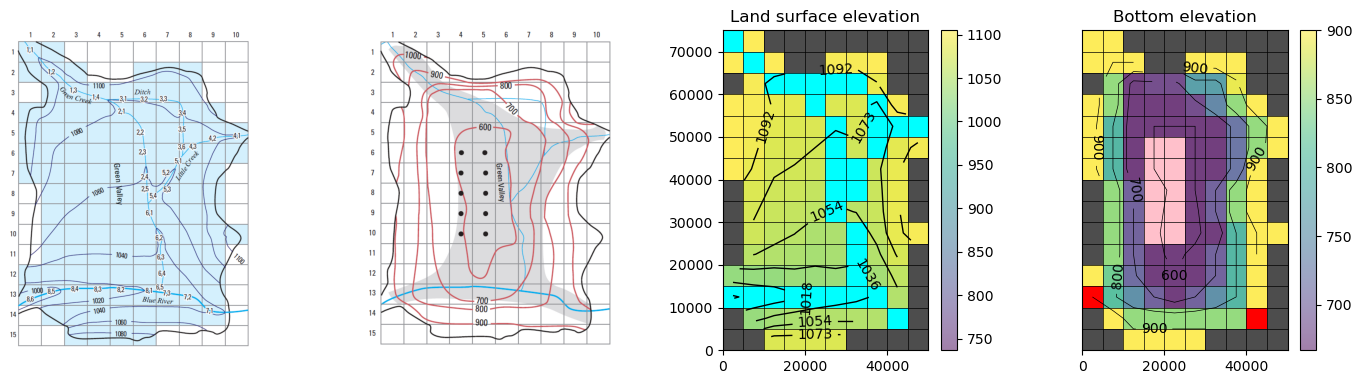

In [ ]:
fig = plt.figure(figsize=(15, 4), dpi=100)        
ax = fig.add_subplot(141) ;image=plt.imread('E:/15_REPOS/00_BETAMI/00_MF6/_aux/30_11_SRF2.png') ;ax.imshow(image) ;ax.axis('off')
ax = fig.add_subplot(142) ;image=plt.imread('E:/15_REPOS/00_BETAMI/00_MF6/_aux/30_11_SRF1.png') ;ax.imshow(image) ;ax.axis('off')
plt.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)
ax = fig.add_subplot(143)  ; mm = flopy.plot.PlotMapView(ml, ax=ax)
top_coll = mm.plot_array(top, vmin=np.max(top[0])/1.5, vmax=np.max(top[0]), masked_values=(0, 1e30, -1e30), alpha=0.5)    
cbar     = plt.colorbar(top_coll, ax=ax, format="%.0f")                                                            ; ax.set_title("Land surface elevation")
cv       = mm.contour_array(top,levels=lev_top,linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(cv, fmt="%1.0f") ; mm.plot_inactive(color_noflow=".3") ; mm.plot_bc("SFR", color="cyan")                   ; mm.plot_grid(lw=0.5, color="black")
ax = fig.add_subplot(144)  ; mm = flopy.plot.PlotMapView(ml, ax=ax )
bot_coll = mm.plot_array(botm, vmin=np.max(botm[0])/1.5, vmax=np.max(botm[0])*.9, masked_values=(0, 1e30, -1e30), alpha=0.5)
cbar = plt.colorbar(bot_coll, ax=ax, format="%.0f")                                                                      ; ax.set_title("Bottom elevation")
ct = mm.contour_array(botm,levels=lev_bot,linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(ct, fmt="%1.0f"); mm.plot_inactive(color_noflow="0.3") ; mm.plot_bc("GHB", color="red")  ; mm.plot_bc("WEL", color="pink", kper=1)       
mm.plot_grid(lw=0.5, color="black") ; ax.yaxis.set_visible(False) ; plt.show() 

Min H 993.0 ____ Min H pump 927.0


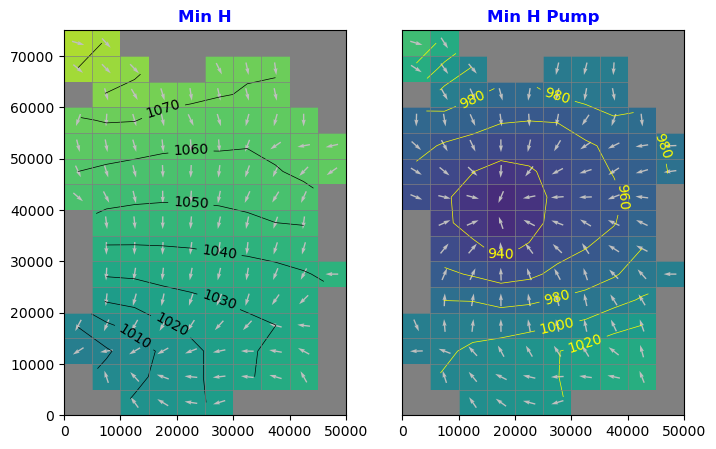

In [25]:
fig = plt.figure(figsize=(8, 5))                              ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))
ax = fig.add_subplot(121)       ; ax.set_title('Min H',fontweight='bold', color = 'blue')     ; mm = flopy.plot.PlotMapView(ml, ax=ax, extent=extents)  
head_coll = mm.plot_array(head0, vmin=900, vmax=1120,     masked_values=(0, 1e30, -1e30))     ; mm.plot_inactive(color_noflow="0.3")
cv = mm.contour_array(head0,levels=np.arange(900, 1100, 10),linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(cv, fmt="%1.0f") ; mm.plot_vector(qx0, qy0,      normalize=True, color="0.75")     ; mm.plot_inactive(color_noflow="0.5") ; mm.plot_grid(lw=0.5)
ax = fig.add_subplot(122) ; ax.set_title('Min H Pump', fontweight='bold', color = 'blue')     ; mm = flopy.plot.PlotMapView(ml, ax=ax, extent=extents)  
head_coll = mm.plot_array(head1, vmin=900, vmax=1120,     masked_values=(0, 1e30, -1e30))     ; mm.plot_inactive(color_noflow="0.3")
cv = mm.contour_array(head1,levels=np.arange(900, 1100, 20),linewidths=0.5,linestyles="-",colors="yellow",masked_values=(0, 1e30, -1e30))
plt.clabel(cv, fmt="%1.0f") ; mm.plot_vector(qx1, qy1, normalize=True, color="0.75")          ; mm.plot_inactive(color_noflow="0.5") ; mm.plot_grid(lw=0.5)
ax.yaxis.set_visible(False) ; plt.show()                  

In [9]:
df = pd.read_csv(sim_ws/'sfr-p01.sfr.obs.csv')  ; print(df.columns)

Index(['time', 'R01_STAGE', 'R02_STAGE', 'R03_STAGE', 'R04_STAGE', 'R01_FLOW',
       'R02_FLOW', 'R03_FLOW', 'R04_FLOW'],
      dtype='object')


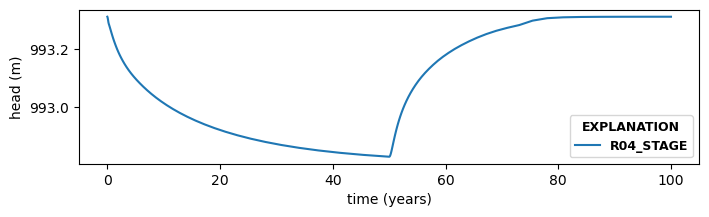

In [10]:
pt_stage = 'R04_STAGE'                                               ; df = pd.read_csv(sim_ws/'sfr-p01.sfr.obs.csv') 
df['T2']=df['time']/(365.25*86400.0)     ; df['time']=df['T2']       ; df = df.drop(columns=['T2'])  
fig, ax = plt.subplots(figsize=(8, 2))   ; ax.plot(df['time']        , df[pt_stage], label= pt_stage,  color='C0')  
ax.set_xlabel("time (years)")            ; ax.set_ylabel("head (m)") ; styles.graph_legend(ax) ; plt.show()

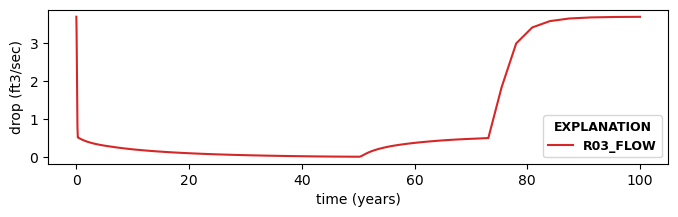

In [11]:
pt_flow = 'R03_FLOW'                                                 ; df = pd.read_csv(sim_ws/'sfr-p01.sfr.obs.csv')  
df['R01_FLOW']=df['R01_FLOW']*-1;df['R02_FLOW']=df['R02_FLOW']*-1    ; df['R03_FLOW']=df['R03_FLOW']*-1;df['R04_FLOW']=df['R04_FLOW']*-1 
df['T2']=df['time']/(365.25*86400.0)           ; df['time']=df['T2'] ; df = df.drop(columns=['T2'])  
fig, ax = plt.subplots(figsize=(8, 2))         ; ax.plot(df['time']  , df[pt_flow], label= pt_flow,  color='C3')  
ax.set_xlabel("time (years)") ; ax.set_ylabel("drop (ft3/sec)")      ; styles.graph_legend(ax) ; plt.show()